In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns

In [2]:
demand_bookings_df = pd.read_csv('./hotel_bookings.csv')
demand_bookings_df.rename(columns = {
    'adults': 'no_of_adults',
    'children': 'no_of_children',
    'stays_in_weekend_nights': 'no_of_weekend_nights',
    'stays_in_week_nights': 'no_of_week_nights',
    'meal': 'type_of_meal_plan',
    'required_car_parking_spaces': 'required_car_parking_space',
    'reserved_room_type': 'room_type_reserved',
    'lead_time': 'lead_time',
    'arrival_date_year': 'arrival_year',
    'arrival_date_month': 'arrival_month',
    'arrival_date_day_of_month': 'arrival_date',
    'market_segment': 'market_segment_type',
    'is_repeated_guest': 'repeated_guest',
    'previous_cancellations': 'no_of_previous_cancellations',
    'previous_bookings_not_canceled': 'no_of_previous_bookings_not_canceled',
    'adr': 'avg_price_per_room',
    'total_of_special_requests': 'no_of_special_requests',
    'is_canceled': 'booking_status'
}, inplace=True)

demand_bookings_df['arrival_month'] = demand_bookings_df['arrival_month'].map({
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
})

demand_bookings_df['type_of_meal_plan'] = \
    demand_bookings_df['type_of_meal_plan'].map({
        'BB': 0, 'HB': 2, 'SC': 1, 'Undefined': 1, 'FB': 3
    })

demand_bookings_df['market_segment_type'] = \
    demand_bookings_df['market_segment_type'].map({
        "'Online TA": 1, "Offline TA/TO": 0, "Corporate": 2, "Complementary": 4, "Aviation": 3
    })

demand_bookings_df['room_type_reserved'] = \
    demand_bookings_df['room_type_reserved'].map({
        'A':  0, 'D':  1, 'E':  3, 'F':  2, 'G':  4, 'B':  5, 'C':  6
    })

demand_bookings_df['market_segment_type'].fillna(5, inplace=True)
demand_bookings_df['room_type_reserved'].fillna(7, inplace=True)

In [3]:
train = pd.read_csv('./train.csv').drop('id',axis=1)
cols = train.columns
origin = pd.read_csv('./archive/train__dataset.csv')
train = pd.concat([train,origin,demand_bookings_df],axis=0).drop_duplicates().reset_index(drop=True) # demand_bookings_df
test = pd.read_csv('./test.csv').drop('id',axis=1)

In [4]:
train = train.loc[:,cols]
train['guest'] = train['no_of_adults'] + train['no_of_children']
test['guest'] = test['no_of_adults'] + test['no_of_children']

In [5]:
train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status,guest
0,2,0.0,0,2,1,0,0.0,9,2018,1,14,1.0,1,11,0,67.50,0,0,2.0
1,2,0.0,1,2,0,0,0.0,117,2018,7,29,0.0,0,0,0,72.25,0,0,2.0
2,2,0.0,0,1,0,0,0.0,315,2018,12,2,0.0,0,0,0,52.00,0,0,2.0
3,1,0.0,0,2,1,0,0.0,32,2018,12,1,1.0,0,0,0,56.00,0,0,1.0
4,2,0.0,1,0,0,0,0.0,258,2018,10,16,0.0,0,0,0,100.00,0,1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141961,2,0.0,2,5,0,0,0.0,23,2017,8,30,0.0,0,0,0,96.14,0,0,2.0
141962,3,0.0,2,5,0,0,3.0,102,2017,8,31,5.0,0,0,0,225.43,2,0,3.0
141963,2,0.0,2,5,0,0,1.0,34,2017,8,31,5.0,0,0,0,157.71,4,0,2.0
141964,2,0.0,2,5,0,0,0.0,109,2017,8,31,5.0,0,0,0,104.40,0,0,2.0


<AxesSubplot: ylabel='Frequency'>

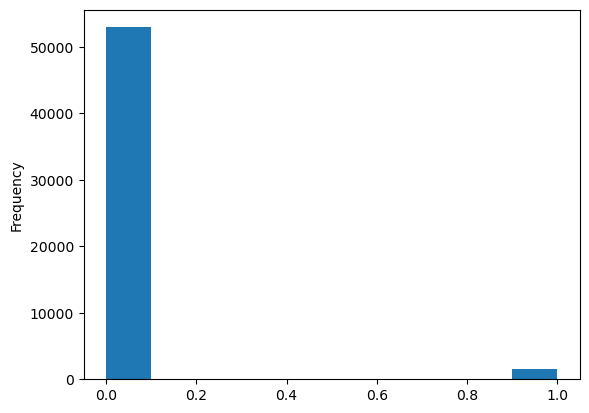

In [5]:
train.required_car_parking_space.plot.hist()

In [6]:
drop_target = ['arrival_year','no_of_previous_cancellations','arrival_date','no_of_previous_bookings_not_canceled',
               'no_of_children','repeated_guest','required_car_parking_space']
train = train.drop(drop_target,axis=1)
test = test.drop(drop_target,axis=1)

In [7]:
train.booking_status.value_counts()

0    34612
1    19961
Name: booking_status, dtype: int64

In [8]:
from pycaret import classification
classification.setup(session_id=41,data=train,target='booking_status')

,Description,Value
0,session_id,41
1,Target,booking_status
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(54573, 12)"
5,Missing Values,False
6,Numeric Features,2
7,Categorical Features,9
8,Ordinal Features,False
9,High Cardinality Features,False


([('Setup Config',
                                  Description             Value
   0                               session_id                41
   1                                   Target    booking_status
   2                              Target Type            Binary
   3                            Label Encoded              None
   4                            Original Data       (54573, 12)
   5                           Missing Values             False
   6                         Numeric Features                 2
   7                     Categorical Features                 9
   8                         Ordinal Features             False
   9                High Cardinality Features             False
   10                 High Cardinality Method              None
   11                   Transformed Train Set       (38201, 77)
   12                    Transformed Test Set       (16372, 77)
   13                      Shuffle Train-Test              True
   14                

In [9]:
best = classification.compare_models(sort='AUC',n_select=4,fold=10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8249,0.8945,0.7312,0.7773,0.7535,0.6180,0.6187,6.5850
catboost,CatBoost Classifier,0.8237,0.8936,0.7230,0.7795,0.7501,0.6142,0.6153,10.6640
lightgbm,Light Gradient Boosting Machine,0.8223,0.8914,0.7230,0.7761,0.7486,0.6114,0.6123,0.4490
gbc,Gradient Boosting Classifier,0.8109,0.8777,0.6944,0.7669,0.7288,0.5841,0.5859,4.7170
ada,Ada Boost Classifier,0.7957,0.8667,0.6930,0.7342,0.7129,0.5546,0.5552,1.3530
rf,Random Forest Classifier,0.7913,0.8543,0.6826,0.7298,0.7054,0.5441,0.5448,2.4480
lr,Logistic Regression,0.7846,0.8510,0.6529,0.7301,0.6893,0.5253,0.5273,3.2680
lda,Linear Discriminant Analysis,0.7817,0.8490,0.6519,0.7242,0.6861,0.5195,0.5212,0.5230
knn,K Neighbors Classifier,0.7643,0.8112,0.6429,0.6915,0.6662,0.4844,0.4852,0.7090
et,Extra Trees Classifier,0.7604,0.8031,0.6433,0.6835,0.6627,0.4772,0.4778,3.1900


In [ ]:
best_tune = [classification.tune_model(i) for i in best]

IntProgress(value=0, description='Processing: ', max=7)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:52:53
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Extreme Gradient Boosting


,Fold,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC


Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
best_tune

In [ ]:
best_tune[0].get_params()

In [ ]:
best_tune[1].get_params()

In [ ]:
import catboost
params = best_tune[1].get_params()
cat = catboost.CatBoostClassifier(**params)
cat.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_cat = cat.predict_proba(test)

In [ ]:
import xgboost
params = best_tune[0].get_params()
xgb = xgboost.XGBClassifier(**params)
xgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_xgb = xgb.predict_proba(test)

In [ ]:
import lightgbm
params = best_tune[2].get_params()
lgb = lightgbm.LGBMClassifier(**params)
lgb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_lgb = lgb.predict_proba(test)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
params = best_tune[3].get_params()
gb = GradientBoostingClassifier(**params)
gb.fit(train.drop('booking_status',axis=1),train['booking_status'])
proba_ggb = gb.predict_proba(test)

In [ ]:
proba = [proba_cat,proba_xgb,proba_lgb,proba_ggb]
proba = [[j[1] for j in i] for i in proba]

In [ ]:
import matplotlib.pyplot as plt
plt.barh(cat.feature_names_,cat.feature_importances_)

In [ ]:
plt.barh(cat.feature_names_,xgb.feature_importances_)

In [ ]:
plt.barh(cat.feature_names_,lgb.feature_importances_)

In [ ]:
best_tune

In [ ]:
sub = pd.read_csv('./sample_submission.csv')
sub['booking_status'] = 0.0*np.array(proba[0]) + 0.0*np.array(proba[1]) + 0.6*np.array(proba[2]) + 0.4*np.array(proba[3])# np.array(proba).mean(axis=0)
sub = sub.set_index('id')
sub.to_csv('./submission.csv')

In [ ]:
sub

In [ ]:
sub['booking_status'].plot.hist(bins=100)